## 数据归一化

### 1. 导入需要的库

In [5]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf

#### 1.1 打印版本

In [6]:
for module in keras, pd, np, tf, mpl, sklearn:
    print(module.__name__, module.__version__)

tensorflow.keras 2.4.0
pandas 1.3.3
numpy 1.18.5
tensorflow 2.3.0
matplotlib 3.4.2
sklearn 1.0


### 2. 处理数据集

#### 2.1 导入数据

- mnist数据集 : https://docs.pythontab.com/tensorflow/tutorials/mnist_beginners/#mnist

In [7]:
# 读取tf自带的数据集
fashion_mnist = tf.keras.datasets.fashion_mnist
# 加载数据
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 拆分训练集和验证集的数据
# 共60000张图片, 前5000张为验证集,后面都是测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [8]:
print(np.max(x_train), np.min(x_train))

255 0


In [9]:
# 数据归一化 : x - means / std(方差)

from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()
# 对训练集和验证集做归一化, 另外 验证集归一化的时候需要训练集的均值和方差
# fit_transformer 输入值是二维矩阵, 另外 fit_transformer 会记录训练时的均值和方差
# x_train : [None, 28, 28] => [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.fit_transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

In [11]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


#### 2.2 展示数据

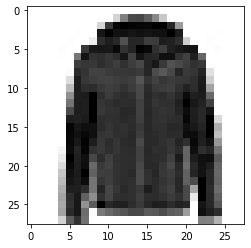

In [12]:
# 数据集都是向量数据, 直接输出无法显示图片, 需要借用matplotlib显示图片
def show_single_image(img_arr):
    # cmp 指的是数据类型
    plt.imshow(img_arr, cmap="binary")
    plt.show()


# 展示图片
show_single_image(x_train[0])

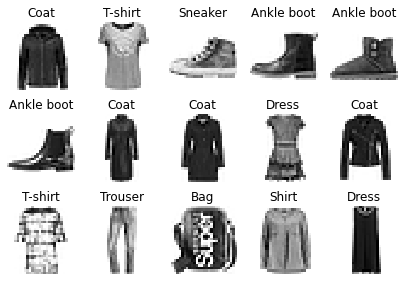

In [13]:
# 展示所有种类的数据
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    # 断言, 判断x_data 和 y_data是否相等
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)

    # 创建画板
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    # 展示不同种类的图像
    for row in range(n_rows):
        for col in range(n_cols):
            # 获取索引
            index = n_cols * row + col
            # plt.subplot 用于绘制子图, 参考 : https://www.cnblogs.com/cgmcoding/p/13279406.html
            plt.subplot(n_rows, n_cols, index + 1)
            # interpolation 缩放图片时使用的方法
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest")
            # 关闭坐标系
            plt.axis('off')
            # 设置标题
            plt.title(class_names[y_data[index]])


class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

### 3. 模型搭建

- Flatten : 输入层, Flatten 将 多维向量展平为一维向量
- Dense :
    1. 实现操作: output = activation(dot(input, kernel) + bias)
    2. 其中 activation 是作为激活参数传递的逐元素激活函数, kernel 是层创建的权重矩阵, bias 是创建的偏置向量

- 激活函数 :
    1. relu : y = max(0, x)
    2. softmax : 将向量变成概率分布 => x = [x1, x2, x3] -> y = [e^x1 / sum, e^x2 / sum, e^x3 / sum], e^x1 + e^x2 +e^x3 = sum

In [14]:
# 创建模型
# model = keras.models.Sequential()
model = keras.models.Sequential()
# 添加输入层, Flatten 将 多维向量展平为一维向量
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 添加全连接层 : units : 当前层的输出维度, activation 激活函数
model.add(keras.layers.Dense(units=300, activation='relu'))
model.add(keras.layers.Dense(units=100, activation='relu'))
# 因为总共分类是10个分类, 所以, 输出层我们设置为 10
# softmax 是将向量转换为 概率分布
model.add(keras.layers.Dense(units=10, activation='softmax'))

"""
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
"""

# 设置损失函数 , 损失函数可以查看 tf.keras.losses.Loss
# categorical_crossentropy 交叉熵损失函数
# y值, 也就是真实值, 处理分类问题时, 我们需要把类别使用 one-hot 转换为 向量, 如果 y已经是一个向量, 那么我们使用 categorical_crossentropy 即可
# 如果y只是一个数字, 而不是向量, 那么我们需要使用 sparse_categorical_crossentropy
# 优化函数 : optimizer = sgd (随机梯度下降) : 参考 https://blog.csdn.net/weixin_46301248/article/details/105883723
# 显示的指标 : accuracy(准确度)
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [15]:
# 查看模型的层数
model.layers

In [16]:
# 展示模型的架构, 以及可训练参数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


- 全连接层参数计算
- [None, 784] * W + b(偏置) -> [None, 300] => W (参数) shape = [784, 300], b = [300] => 784 * 300 + 300 = 235500

In [17]:
# 训练模型
# epochs : 训练轮数, validation_data : 验证集, 类型为 tuple(x_valid, y_valid)
# 返回值是训练过程中运行的一些数据结果
history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid))

# print(x_train.shape, y_train.shape)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5510 - accuracy: 0.8074 - val_loss: 0.4219 - val_accuracy: 0.8532

In [18]:
type(history)

tensorflow.python.keras.callbacks.History

In [19]:
# GPU 和 CPU 训练的结果有很大不同
history.history

{'loss': [0.5509964823722839,
  0.3947769105434418,
  0.35416850447654724,
  0.3289996087551117,
  0.3087013065814972,
  0.29294341802597046,
  0.27911320328712463,
  0.2668841481208801,
  0.25579509139060974,
  0.24703897535800934],
 'accuracy': [0.807381808757782,
  0.8581091165542603,
  0.8718181848526001,
  0.8808909058570862,
  0.8873090744018555,
  0.893854558467865,
  0.8986363410949707,
  0.9033272862434387,
  0.9065454602241516,
  0.9109818339347839],
 'val_loss': [0.4219070374965668,
  0.3875962793827057,
  0.35232335329055786,
  0.3505503237247467,
  0.332782506942749,
  0.32016146183013916,
  0.32339510321617126,
  0.30522724986076355,
  0.3213913142681122,
  0.32875487208366394],
 'val_accuracy': [0.8532000184059143,
  0.8655999898910522,
  0.8704000115394592,
  0.8730000257492065,
  0.883400022983551,
  0.8838000297546387,
  0.881600022315979,
  0.8884000182151794,
  0.8838000297546387,
  0.8830000162124634]}

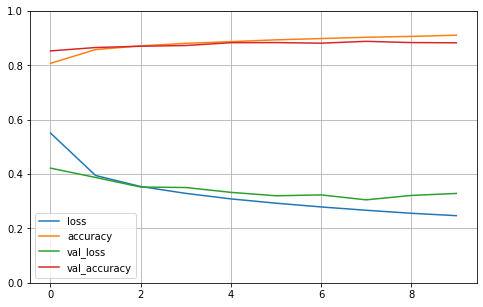

In [20]:
# 绘制图像
def plt_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0, 1)
    # 展示图像
    plt.show()

plt_learning_curves(history)

In [ ]:
# 在测试集上评估
model.evaluate(x_test_scaled, y_test)